In [1]:
"""
file:       dslabs_functions.py
version:    2023.1
author:     Claudia Antunes
"""
from math import pi, sin, cos, ceil, sqrt
from itertools import product
from datetime import datetime
from typing import Callable
from numpy import array, ndarray, arange, std, set_printoptions
from matplotlib.collections import PathCollection
from matplotlib.colorbar import Colorbar
from matplotlib.container import BarContainer
from matplotlib.figure import Figure
from matplotlib.font_manager import FontProperties
from matplotlib.axes import Axes
from matplotlib.pyplot import gca, gcf, savefig, subplots, text
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

# from matplotlib.dates import _reset_epoch_test_example, set_epoch
from pandas import DataFrame, Series, Index, Period
from pandas import read_csv, concat, to_numeric, to_datetime
from pandas.api.types import is_integer_dtype, is_any_real_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_auc_score
from sklearn.naive_bayes import _BaseNB, GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier




NR_COLUMNS: int = 3
HEIGHT: int = 4

TEXT_MARGIN = 0.05
FONT_SIZE = 6
FONT_TEXT = FontProperties(size=FONT_SIZE)

alpha = 0.3

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5

# _reset_epoch_test_example()
# set_epoch('0000-12-31T00:00:00')  # old epoch (pre MPL 3.3)


# ---------------------------------------
#             DATA CHARTS
# ---------------------------------------


def define_grid(nr_vars, vars_per_row: int = NR_COLUMNS) -> tuple[int, int]:
    nr_rows: int = 1
    if nr_vars % vars_per_row == 0:
        nr_rows = nr_vars // vars_per_row
    else:
        nr_rows = nr_vars // vars_per_row + 1
    return nr_rows, vars_per_row


def set_chart_labels(ax: Axes, title: str = "", xlabel: str = "", ylabel: str = "") -> Axes:
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax


def set_chart_xticks(xvalues: list[str | int | float | datetime], ax: Axes, percentage: bool = False) -> Axes:
    if len(xvalues) > 0:
        if percentage:
            ax.set_ylim(0.0, 1.0)

        if isinstance(xvalues[0], datetime):
            locator = AutoDateLocator()
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(AutoDateFormatter(locator, defaultfmt="%Y-%m-%d"))
        rotation: int = 0
        if not any(not isinstance(x, (int, float)) for x in xvalues):
            ax.set_xlim(left=xvalues[0], right=xvalues[-1])
            ax.set_xticks(xvalues, labels=xvalues)
        else:
            rotation = 45

        ax.tick_params(axis="x", labelrotation=rotation, labelsize="xx-small")

    return ax


def plot_line_chart(
    xvalues: list,
    yvalues: list,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    name: str = "",
    percentage: bool = False,
    show_stdev: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax, percentage=percentage)
    if any(y < 0 for y in yvalues) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.plot(xvalues, yvalues, c=LINE_COLOR, label=name)
    if show_stdev:
        stdev: float = round(std(yvalues), 3)
        y_bottom: list[float] = [(y - stdev) for y in yvalues]
        y_top: list[float] = [(y + stdev) for y in yvalues]
        ax.fill_between(xvalues, y_bottom, y_top, color=FILL_COLOR, alpha=0.2)
    return ax


def plot_bar_chart(
    xvalues: list,
    yvalues: list,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax=ax, percentage=percentage)
    values: BarContainer = ax.bar(
        xvalues,
        yvalues,
        label=yvalues,
        edgecolor=LINE_COLOR,
        color=FILL_COLOR,
        tick_label=xvalues,
    )
    format = "%.2f" if percentage else "%.0f"
    ax.bar_label(values, fmt=format, fontproperties=FONT_TEXT)

    return ax


def plot_scatter_chart(
    var1: list,
    var2: list,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax.scatter(var1, var2)
    return ax


def plot_horizontal_bar_chart(
    elements: list,
    values: list,
    error: list = [],
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    if percentage:
        ax.set_xlim((0, 1))
    if error == []:
        error = [0] * len(elements)
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    y_pos: list = list(arange(len(elements)))

    ax.barh(y_pos, values, xerr=error, align="center", error_kw={"lw": 0.5, "ecolor": "r"})
    ax.set_yticks(y_pos, labels=elements)
    ax.invert_yaxis()  # labels read top-to-bottom
    return ax


def plot_multiline_chart(
    xvalues: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax=ax, percentage=percentage)
    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
        if any(v < 0 for v in y) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.legend(legend, fontsize="xx-small")
    return ax


def plot_multibar_chart(
    group_labels: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes | list[Axes]:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    bar_labels: list = list(yvalues.keys())

    # This is the location for each bar
    index: ndarray = arange(len(group_labels))
    bar_width: float = 0.8 / len(bar_labels)
    ax.set_xticks(index + bar_width / 2, labels=group_labels)

    for i in range(len(bar_labels)):
        bar_yvalues = yvalues[bar_labels[i]]
        values: BarContainer = ax.bar(
            index + i * bar_width,
            bar_yvalues,
            width=bar_width,
            label=bar_labels[i],
        )
        format = "%.2f" if percentage else "%.0f"
        ax.bar_label(values, fmt=format, fontproperties=FONT_TEXT)
        if any(y < 0 for y in bar_yvalues) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.legend(fontsize="xx-small")
    return ax


def plot_multi_scatters_chart(
    data: DataFrame, var1: str, var2: str, var3: str = "", ax: Axes = None  # type: ignore
) -> Axes:
    if ax is None:
        ax = gca()

    title: str = f"{var1} x {var2}"
    if var3 != "":
        title += f"per {var3}"
        if is_any_real_numeric_dtype(data[var3]) and not is_integer_dtype(data[var3]):
            chart: PathCollection = ax.scatter(data[var1], data[var2], c=data[var3].to_list())
            cbar: Colorbar = gcf().colorbar(chart)
            cbar.outline.set_visible(False)  # type: ignore
            cbar.set_label(var3, loc="top")
        else:
            values: list = data[var3].unique().tolist()
            values.sort()
            for i in range(len(values)):
                subset: DataFrame = data[data[var3] == values[i]]
                ax.scatter(subset[var1], subset[var2], color=ACTIVE_COLORS[i], label=values[i])
            ax.legend(fontsize="xx-small")
    else:
        ax.scatter(data[var1], data[var2], color=FILL_COLOR)
    ax = set_chart_labels(ax=ax, title=title, xlabel=var1, ylabel=var2)
    return ax


# ---------------------------------------
#             DATA PROFILING
# ---------------------------------------


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=True, threshold=nrstdev)
        outliers_stdev += [data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]]

        top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False, threshold=iqrfactor)
        outliers_iqr += [data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


def derive_date_variables(df: DataFrame, date_vars: list[str]) -> DataFrame:
    for date in date_vars:
        df[date + "_year"] = df[date].dt.year
        df[date + "_quarter"] = df[date].dt.quarter
        df[date + "_month"] = df[date].dt.month
        df[date + "_day"] = df[date].dt.day
    return df


def analyse_date_granularity(data: DataFrame, var: str, levels: list[str]) -> ndarray:
    cols: int = len(levels)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    fig.suptitle(f"Granularity study for {var}")

    for i in range(cols):
        counts: Series[int] = data[var + "_" + levels[i]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[0, i],
            title=levels[i],
            xlabel=levels[i],
            ylabel="nr records",
            percentage=False,
        )
    return axs


def analyse_property_granularity(data: DataFrame, property: str, vars: list[str]) -> ndarray:
    cols: int = len(vars)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    fig.suptitle(f"Granularity study for {property}")
    for i in range(cols):
        counts: Series[int] = data[vars[i]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[0, i],
            title=vars[i],
            xlabel=vars[i],
            ylabel="nr records",
            percentage=False,
        )
    return axs


# ---------------------------------------
#             DATA PREPARATION
# ---------------------------------------


def encode_cyclic_variables(data: DataFrame, vars: list[str]) -> None:
    for v in vars:
        x_max: float | int = max(data[v])
        data[v + "_sin"] = data[v].apply(lambda x: round(sin(2 * pi * x / x_max), 3))
        data[v + "_cos"] = data[v].apply(lambda x: round(cos(2 * pi * x / x_max), 3))
    return


def dummify(df: DataFrame, vars_to_dummify: list[str]) -> DataFrame:
    other_vars: list[str] = [c for c in df.columns if not c in vars_to_dummify]

    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype="bool", drop="if_binary")
    trans: ndarray = enc.fit_transform(df[vars_to_dummify])

    new_vars: ndarray = enc.get_feature_names_out(vars_to_dummify)
    dummy = DataFrame(trans, columns=new_vars, index=df.index)

    final_df: DataFrame = concat([df[other_vars], dummy], axis=1)
    return final_df


def mvi_by_dropping(data: DataFrame, min_pct_per_variable: float = 0.1, min_pct_per_record: float = 0.0) -> DataFrame:
    """
    data: DataFrame - the data to clean
    min_pct_per_variable: float - the minimum percentage of records a variable has to show in order to be kept
    min_pct_per_record: float - the minimum percentage of values that a record has to show in order to be kept
    return the data modified
    """
    # Deleting variables
    df: DataFrame = data.dropna(axis=1, thresh=data.shape[0] * min_pct_per_variable, inplace=False)
    # Deleting records
    df.dropna(axis=0, thresh=data.shape[1] * min_pct_per_record, inplace=True)

    return df


def mvi_by_filling(data: DataFrame, strategy: str = "frequent") -> DataFrame:
    """
    data: DataFrame - the data to clean
    strategy: str - the strategy to apply ('frequent', 'constant' or 'knn')
    return the data modified
    """
    df: DataFrame
    variables: dict = get_variable_types(data)
    stg_num, v_num = "mean", -1
    stg_sym, v_sym = "most_frequent", "NA"
    stg_bool, v_bool = "most_frequent", False
    if strategy != "knn":
        lst_dfs: list = []
        if strategy == "constant":
            stg_num, stg_sym, stg_bool = "constant", "constant", "constant"
        if len(variables["numeric"]) > 0:
            imp = SimpleImputer(strategy=stg_num, fill_value=v_num, copy=True)
            tmp_nr = DataFrame(
                imp.fit_transform(data[variables["numeric"]]),
                columns=variables["numeric"],
            )
            lst_dfs.append(tmp_nr)
        if len(variables["symbolic"]) > 0:
            imp = SimpleImputer(strategy=stg_sym, fill_value=v_sym, copy=True)
            tmp_sb = DataFrame(
                imp.fit_transform(data[variables["symbolic"]]),
                columns=variables["symbolic"],
            )
            lst_dfs.append(tmp_sb)
        if len(variables["binary"]) > 0:
            imp = SimpleImputer(strategy=stg_bool, fill_value=v_bool, copy=True)
            tmp_bool = DataFrame(
                imp.fit_transform(data[variables["binary"]]),
                columns=variables["binary"],
            )
            lst_dfs.append(tmp_bool)
        df = concat(lst_dfs, axis=1)
    else:
        imp = KNNImputer(n_neighbors=5)
        imp.fit(data)
        ar: ndarray = imp.transform(data)
        df = DataFrame(ar, columns=data.columns, index=data.index)
    return df


def select_low_variance_variables(data: DataFrame, max_threshold: float, target: str = "class") -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[summary5.loc["std"] * summary5.loc["std"] < max_threshold]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[summary5.loc["std"] * summary5.loc["std"] < thresh]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(train_copy, test_copy, target=target, metric=metric)
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


def select_redundant_variables(data: DataFrame, min_threshold: float = 0.90, target: str = "class") -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [round(min_threshold + i * lag, 3) for i in range(ceil((1 - min_threshold) / lag) + 1)]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(train_copy, test_copy, target=target, metric=metric)
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


from pandas import DataFrame

def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
    train_path: str,
    test_path: str,
) -> tuple[DataFrame, DataFrame]:
    """
    Entfernt ausgewählte Variablen aus den Trainings- und Testdaten
    und speichert die resultierenden DataFrames in den angegebenen Pfaden.

    Args:
        train (DataFrame): Trainingsdatensatz.
        test (DataFrame): Testdatensatz.
        vars2drop (list): Liste der Variablen, die entfernt werden sollen.
        train_path (str): Pfad für die gespeicherte Trainingsdatei.
        test_path (str): Pfad für die gespeicherte Testdatei.

    Returns:
        tuple[DataFrame, DataFrame]: Bereinigte Trainings- und Testdaten.
    """
    # Entfernen der Variablen aus den Datensätzen
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    
    # Speichern der bereinigten DataFrames
    train_copy.to_csv(train_path, index=True)
    test_copy.to_csv(test_path, index=True)
    
    return train_copy, test_copy


# Pfade anpassen
train_path = "/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/Financial_training_data.csv"
test_path = "/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/Financial_testing_data.csv"

# Beispielaufruf der Funktion
# train, test = apply_feature_selection(train_data, test_data, vars_to_drop, train_path, test_path)



# ---------------------------------------
#             CLASSIFICATION
# ---------------------------------------


DELTA_IMPROVE: float = 0.001


CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}


def run_NB(trnX, trnY, tstX, tstY, metric: str = "accuracy") -> dict[str, float]:
    estimators: dict[str, GaussianNB | MultinomialNB | BernoulliNB] = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }
    best_model: GaussianNB | MultinomialNB | BernoulliNB = None  # type: ignore
    best_performance: float = 0.0
    eval: dict[str, float] = {}

    for clf in estimators:
        estimators[clf].fit(trnX, trnY)
        prdY: ndarray = estimators[clf].predict(tstX)
        performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model = estimators[clf]
    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)
        for key in CLASS_EVAL_METRICS:
            eval[key] = CLASS_EVAL_METRICS[key](tstY, prd)
    return eval


def run_KNN(trnX, trnY, tstX, tstY, metric="accuracy") -> dict[str, float]:
    kvalues: list[int] = [1] + [i for i in range(5, 26, 5)]
    best_model: KNeighborsClassifier = None  # type: ignore
    best_performance: float = 0
    eval: dict[str, float] = {}
    for k in kvalues:
        clf = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
        clf.fit(trnX, trnY)
        prdY: ndarray = clf.predict(tstX)
        performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model: KNeighborsClassifier = clf
    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)
        for key in CLASS_EVAL_METRICS:
            eval[key] = CLASS_EVAL_METRICS[key](tstY, prd)
    return eval


def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval


def read_train_test_from_files(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col=None)
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()


def plot_confusion_matrix(cnf_matrix: ndarray, classes_names: ndarray, ax: Axes = None) -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    title = "Confusion matrix"
    set_printoptions(precision=2)
    tick_marks: ndarray = arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cnf_matrix, interpolation="nearest", cmap=cmap_blues)

    for i, j in product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(j, i, format(cnf_matrix[i, j], "d"), color="y", horizontalalignment="center")
    return ax


def plot_roc_chart(tstY: ndarray, predictions: dict, ax: Axes = None, target: str = "class") -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.set_title("ROC chart for %s" % target)

    ax.plot(
        [0, 1],
        [0, 1],
        color="navy",
        label="random",
        linewidth=1,
        linestyle="--",
        marker="",
    )
    models = list(predictions.keys())
    for i in range(len(models)):
        RocCurveDisplay.from_predictions(
            y_true=tstY,
            y_pred=predictions[models[i]],
            name=models[i],
            ax=ax,
            color=ACTIVE_COLORS[i],
            linewidth=1,
        )
    ax.legend(loc="lower right", fontsize="xx-small")
    return ax


def plot_evaluation_results(model, trn_y, prd_trn, tst_y, prd_tst, labels: ndarray) -> ndarray:
    evaluation: dict = {}
    for key in CLASS_EVAL_METRICS:
        evaluation[key] = [
            CLASS_EVAL_METRICS[key](trn_y, prd_trn),
            CLASS_EVAL_METRICS[key](tst_y, prd_tst),
        ]

    params_st: str = "" if () == model["params"] else str(model["params"])
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    fig.suptitle(f'Best {model["metric"]} for {model["name"]} {params_st}')
    plot_multibar_chart(["Train", "Test"], evaluation, ax=axs[0], percentage=True)

    cnf_mtx_tst: ndarray = confusion_matrix(tst_y, prd_tst, labels=labels)
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])
    return axs


# ---------------------------------------
#             TIME SERIES
# ---------------------------------------


from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose


def plot_ts_multivariate_chart(data: DataFrame, title: str) -> list[Axes]:
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(data.shape[1], 1, figsize=(3 * HEIGHT, HEIGHT / 2 * data.shape[1]))
    fig.suptitle(title)

    for i in range(data.shape[1]):
        col: str = data.columns[i]
        auxi_ax: Axes = plot_line_chart(
            data[col].index.to_list(),
            data[col].to_list(),
            ax=axs[i],
            xlabel=data.index.name,
            ylabel=col,
        )
        auxi_ax.tick_params(axis="x", labelbottom="off")
    return axs


def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
) -> list[Axes]:
    decomposition: DecomposeResult = seasonal_decompose(series, model="add")
    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }
    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")
    i: int = 0
    for key in components:
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])
        i += 1
    return axs


# ---------------------------------------
#       TIME SERIES TRANSFORMATION
# ---------------------------------------


def ts_aggregation_by(
    data: Series | DataFrame,
    gran_level: str = "D",
    agg_func: str = "mean",
) -> Series | DataFrame:
    df: Series | DataFrame = data.copy()
    index: Index[Period] = df.index.to_period(gran_level)
    df = df.groupby(by=index, dropna=True, sort=True).agg(agg_func)
    df.index.drop_duplicates()
    df.index = df.index.to_timestamp()

    return df


def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: Series = data.copy()
    train: Series = df_cp.iloc[:trn_size, 0]
    test: Series = df_cp.iloc[trn_size:, 0]
    return train, test

def dataframe_temporal_train_test_split(data: DataFrame, trn_pct: float = 0.90) -> tuple[DataFrame, DataFrame]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: DataFrame = data.copy()
    train: DataFrame = df_cp.iloc[:trn_size]
    test: DataFrame = df_cp.iloc[trn_size:]
    return train, test


# ---------------------------------------
#             FORECASTING
# ---------------------------------------

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


FORECAST_MEASURES = {
    "MSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "R2": r2_score,
    "MAPE": mean_absolute_percentage_error,
}


def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)

    return axs


Train#=442 Test#=190
Labels=[0, 1]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

MLP best for 500 iterations (lr_type=constant and lr=0.5


<Figure size 640x480 with 0 Axes>

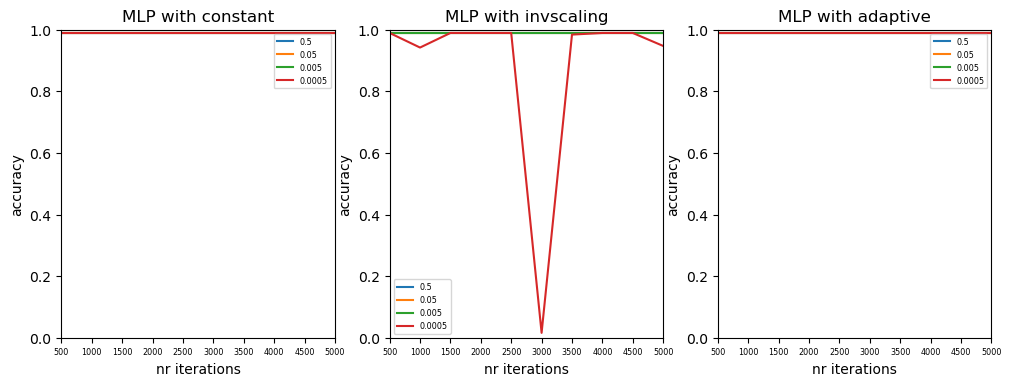

In [8]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier


LAG: int = 500
NR_MAX_ITER: int = 5000


def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                # print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params


file_tag = "stroke"
train_filename = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/Financial_training_data.csv"
test_filename = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/Financial_testing_data.csv"
target = "CLASS"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=NR_MAX_ITER,
    lag=LAG,
    metric=eval_metric,
)
savefig(f"/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling{eval_metric}_study.png")
show()

<Figure size 640x480 with 0 Axes>

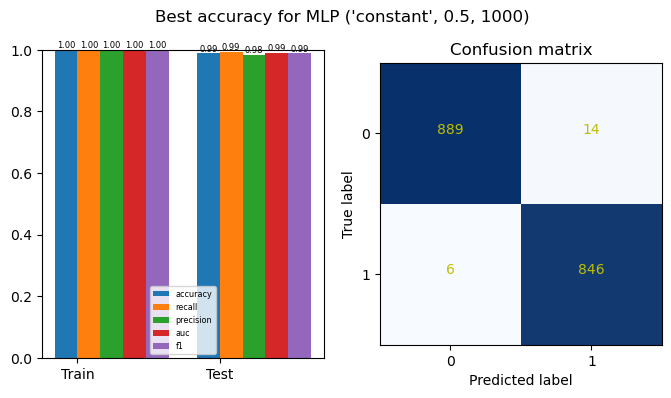

In [6]:
from matplotlib.colors import LinearSegmentedColormap

blues = ["#f7fbff", "#08306b"]  # Define the blues color list
cmap_blues = LinearSegmentedColormap.from_list("myCMPBlues", blues)
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/images{file_tag}_mlp_{params["name"]}_best_{params["metric"]}_eval.png')
show()

In [7]:
from sklearn.neural_network import MLPClassifier
from matplotlib.pyplot import subplots, figure, savefig, show
eval_metric = "accuracy"  # Define the eval_metric variable

params = {
    "name": "MLP",
    "metric": eval_metric,
    "params": ("constant", 0.005, 1500)  # Example values, replace with actual values if needed
}

from typing import Literal  # Literal importieren

train_filename = "/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/sampled_train_data.csv"
test_filename = "/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/sampled_test_data.csv"
target = "CLASS"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target)

eval_metric = "accuracy"  # Define the eval_metric variable

LAG: int = 500  # Ensure LAG is defined
NR_MAX_ITER: int = 5000  # Ensure NR_MAX_ITER is defined

params = {
    "name": "MLP",
    "metric": eval_metric,
    "params": ("constant", 0.5, 1500)  # Example values, replace with actual values if needed
}

lr_type: Literal["constant", "invscaling", "adaptive"] = params["params"][0]
lr: float = params["params"][1]

nr_iterations: list[int] = [LAG] + [i for i in range(2 * LAG, NR_MAX_ITER + 1, LAG)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/images{eval_metric}_overfitting.png")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/sampled_train_data.csv'

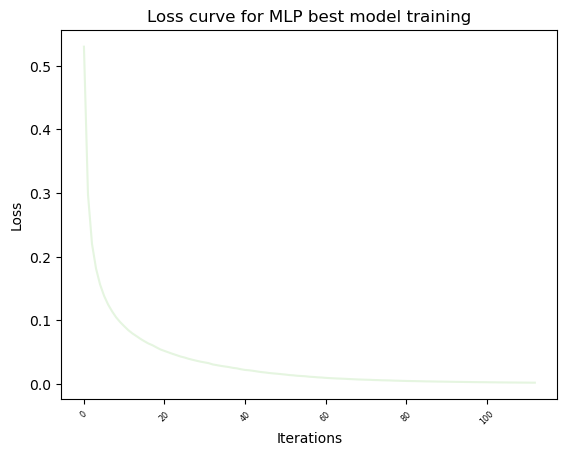

In [21]:
from numpy import arange
from seaborn import color_palette
from matplotlib.pyplot import figure, savefig
from sklearn.neural_network import MLPClassifier

# Ensure best_model is properly defined and trained
best_model = MLPClassifier(max_iter=1000)  # Example, adjust parameters as needed
best_model.fit(trnX, trnY)

# Define line color using a valid color palette
LINE_COLOR = color_palette("Greens", 7)[0]  # Use 'Greens' as a valid color palette

# Create the loss curve plot
figure()
plot_line_chart(
    arange(len(best_model.loss_curve_)),  # X-axis: Iterations
    best_model.loss_curve_,              # Y-axis: Loss values
    title="Loss curve for MLP best model training",
    xlabel="Iterations",
    ylabel="Loss",
    percentage=False,
)

# Save the figure
savefig(
    f"/Users/dominikfrank/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/Projeto/Modeling/images_{eval_metric}_loss_curve.png"
)
